# **Data Science Capstone - Car Accident Severity**

### Kedar Tripathy

## Data Source

https://www.kaggle.com/sobhanmoosavi/us-accidents

## Acknowledgements

- Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, and Rajiv Ramnath. “A Countrywide Traffic Accident Dataset.”, 2019.

- Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, Radu Teodorescu, and Rajiv Ramnath. "Accident Risk Prediction based on Heterogeneous Sparse Data: New Dataset and Insights." In proceedings of the 27th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems, ACM, 2019.

In [1]:
# Import numpy, pandas, matpltlib.pyplot, sklearn modules and seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
plt.style.use('ggplot')

# Import KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier

# Import DecisionTreeClassifier from sklearn.tree
from sklearn.tree import DecisionTreeClassifier

# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

In [2]:
# Import the data
df = pd.read_csv('US_Accidents_June20.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3513617 entries, 0 to 3513616
Data columns (total 49 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   TMC                    float64
 3   Severity               int64  
 4   Start_Time             object 
 5   End_Time               object 
 6   Start_Lat              float64
 7   Start_Lng              float64
 8   End_Lat                float64
 9   End_Lng                float64
 10  Distance(mi)           float64
 11  Description            object 
 12  Number                 float64
 13  Street                 object 
 14  Side                   object 
 15  City                   object 
 16  County                 object 
 17  State                  object 
 18  Zipcode                object 
 19  Country                object 
 20  Timezone               object 
 21  Airport_Code           object 
 22  Weather_Timestamp 

# Data Wrangling

**Step 1: Extract year, month, day, hour, weekday, and time to clear accidents from Start_Time and End_Time**

In [3]:
# Convert Start_Time and End_Time to datetypes
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

# Extract year, month, day, hour and weekday
df['Year']=df['Start_Time'].dt.year
df['Month']=df['Start_Time'].dt.strftime('%b')
df['Day']=df['Start_Time'].dt.day
df['Hour']=df['Start_Time'].dt.hour
df['Weekday']=df['Start_Time'].dt.strftime('%a')

# Extract the amount of time in the unit of minutes for each accident, round to the nearest integer
td='Time_Duration(min)'
df[td]=round((df['End_Time']-df['Start_Time'])/np.timedelta64(1,'m'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3513617 entries, 0 to 3513616
Data columns (total 55 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   Source                 object        
 2   TMC                    float64       
 3   Severity               int64         
 4   Start_Time             datetime64[ns]
 5   End_Time               datetime64[ns]
 6   Start_Lat              float64       
 7   Start_Lng              float64       
 8   End_Lat                float64       
 9   End_Lng                float64       
 10  Distance(mi)           float64       
 11  Description            object        
 12  Number                 float64       
 13  Street                 object        
 14  Side                   object        
 15  City                   object        
 16  County                 object        
 17  State                  object        
 18  Zipcode               

**Step 2: Deal with outliers**

In [4]:
# Check if there is any negative time_duration values
df[td][df[td]<=0]

69719      -0.0
69720      -0.0
69721      -0.0
69722      -1.0
69723      -1.0
309387    -30.0
309388    -30.0
860988    -12.0
861024    -31.0
861041     -0.0
861475    -14.0
861494     -0.0
861495    -30.0
1497823   -30.0
1497824   -31.0
2234574   -30.0
2234659   -30.0
2234660   -31.0
3104499   -34.0
3104975    -7.0
3104978    -7.0
3232740   -31.0
Name: Time_Duration(min), dtype: float64

In [5]:
# Drop the rows with td<0

neg_outliers=df[td]<=0

# Set outliers to NAN
df[neg_outliers] = np.nan

# Drop rows with negative td
df.dropna(subset=[td],axis=0,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3513595 entries, 0 to 3513616
Data columns (total 55 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   Source                 object        
 2   TMC                    float64       
 3   Severity               float64       
 4   Start_Time             datetime64[ns]
 5   End_Time               datetime64[ns]
 6   Start_Lat              float64       
 7   Start_Lng              float64       
 8   End_Lat                float64       
 9   End_Lng                float64       
 10  Distance(mi)           float64       
 11  Description            object        
 12  Number                 float64       
 13  Street                 object        
 14  Side                   object        
 15  City                   object        
 16  County                 object        
 17  State                  object        
 18  Zipcode               

In [6]:
# Double check to make sure no more negative td
df[td][df[td]<=0]

Series([], Name: Time_Duration(min), dtype: float64)

In [7]:
# Remove outliers for Time_Duration(min): n * standard_deviation (n=3), backfill with median

n=3

median = df[td].median()
std = df[td].std()
outliers = (df[td] - median).abs() > std*n

# Set outliers to NAN
df[outliers] = np.nan

# Fill NAN with median
df[td].fillna(median, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3513595 entries, 0 to 3513616
Data columns (total 55 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   Source                 object        
 2   TMC                    float64       
 3   Severity               float64       
 4   Start_Time             datetime64[ns]
 5   End_Time               datetime64[ns]
 6   Start_Lat              float64       
 7   Start_Lng              float64       
 8   End_Lat                float64       
 9   End_Lng                float64       
 10  Distance(mi)           float64       
 11  Description            object        
 12  Number                 float64       
 13  Street                 object        
 14  Side                   object        
 15  City                   object        
 16  County                 object        
 17  State                  object        
 18  Zipcode               

**Step 3: Dropping unneeded data for Machine Learning**

In [8]:
# Set the list of features to include in Machine Learning
feature_lst=['ID','Source','TMC','Severity','Start_Lng','Start_Lat','Distance(mi)','Side','City',
             'County','State','Timezone','Temperature(F)','Humidity(%)','Pressure(in)', 
             'Visibility(mi)', 'Wind_Direction','Weather_Condition','Amenity','Bump','Crossing',
             'Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop',
             'Traffic_Calming','Traffic_Signal','Turning_Loop','Sunrise_Sunset','Hour','Weekday', 
             'Time_Duration(min)']

In [9]:
df_sel=df[feature_lst].copy()
df_sel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3513595 entries, 0 to 3513616
Data columns (total 35 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ID                  object 
 1   Source              object 
 2   TMC                 float64
 3   Severity            float64
 4   Start_Lng           float64
 5   Start_Lat           float64
 6   Distance(mi)        float64
 7   Side                object 
 8   City                object 
 9   County              object 
 10  State               object 
 11  Timezone            object 
 12  Temperature(F)      float64
 13  Humidity(%)         float64
 14  Pressure(in)        float64
 15  Visibility(mi)      float64
 16  Wind_Direction      object 
 17  Weather_Condition   object 
 18  Amenity             float64
 19  Bump                float64
 20  Crossing            float64
 21  Give_Way            float64
 22  Junction            float64
 23  No_Exit             float64
 24  Railway             floa

In [10]:
# Check to see if there are any NaN values
df_sel.isnull().sum()

ID                        680
Source                    680
TMC                   1034842
Severity                  680
Start_Lng                 680
Start_Lat                 680
Distance(mi)              680
Side                      680
City                      792
County                    680
State                     680
Timezone                 4560
Temperature(F)          66385
Humidity(%)             70340
Pressure(in)            56541
Visibility(mi)          76510
Wind_Direction          59538
Weather_Condition       76791
Amenity                   680
Bump                      680
Crossing                  680
Give_Way                  680
Junction                  680
No_Exit                   680
Railway                   680
Roundabout                680
Station                   680
Stop                      680
Traffic_Calming           680
Traffic_Signal            680
Turning_Loop              680
Sunrise_Sunset            795
Hour                      680
Weekday   

In [11]:
# Dropping all NaN values
df_sel.dropna(subset=df_sel.columns[df_sel.isnull().mean()!=0], how='any', axis=0, inplace=True)
df_sel.shape

(2408025, 35)

In [12]:
# Selecting the data for MI only
state='MI'

# Select the state of Michigan
df_state=df_sel.loc[df_sel.State==state]
df_state.drop('State',axis=1, inplace=True)
df_state.head()

C:\Users\tripa\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,ID,Source,TMC,Severity,Start_Lng,Start_Lat,Distance(mi),Side,City,County,Timezone,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Hour,Weekday,Time_Duration(min)
178890,A-178892,MapQuest,201.0,2.0,-85.666740,42.963215,0.01,R,Grand Rapids,Kent,US/Eastern,43.0,60.0,29.56,10.0,WSW,Mostly Cloudy,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,Day,15.0,Wed,78.0
178891,A-178893,MapQuest,201.0,2.0,-85.659164,42.955772,0.01,L,Grand Rapids,Kent,US/Eastern,43.0,60.0,29.56,10.0,WSW,Mostly Cloudy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Day,16.0,Wed,61.0
178892,A-178894,MapQuest,201.0,2.0,-83.783752,43.060432,0.01,R,Flushing,Genesee,US/Eastern,48.0,80.0,29.52,10.0,SW,Partly Cloudy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Day,16.0,Wed,60.0
178893,A-178895,MapQuest,201.0,2.0,-83.648453,42.942875,0.01,L,Grand Blanc,Genesee,US/Eastern,48.0,80.0,29.52,10.0,SW,Partly Cloudy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Day,16.0,Wed,46.0
178894,A-178896,MapQuest,201.0,3.0,-83.058128,42.368423,0.01,R,Detroit,Wayne,US/Eastern,55.0,69.0,29.51,10.0,WSW,Partly Cloudy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Day,16.0,Wed,46.0


In [13]:
df_state.reset_index(inplace = True)
df_state.head()

,index,ID,Source,TMC,Severity,Start_Lng,Start_Lat,Distance(mi),Side,City,County,Timezone,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Hour,Weekday,Time_Duration(min)
0,178890,A-178892,MapQuest,201.0,2.0,-85.666740,42.963215,0.01,R,Grand Rapids,Kent,US/Eastern,43.0,60.0,29.56,10.0,WSW,Mostly Cloudy,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,Day,15.0,Wed,78.0
1,178891,A-178893,MapQuest,201.0,2.0,-85.659164,42.955772,0.01,L,Grand Rapids,Kent,US/Eastern,43.0,60.0,29.56,10.0,WSW,Mostly Cloudy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Day,16.0,Wed,61.0
2,178892,A-178894,MapQuest,201.0,2.0,-83.783752,43.060432,0.01,R,Flushing,Genesee,US/Eastern,48.0,80.0,29.52,10.0,SW,Partly Cloudy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Day,16.0,Wed,60.0
3,178893,A-178895,MapQuest,201.0,2.0,-83.648453,42.942875,0.01,L,Grand Blanc,Genesee,US/Eastern,48.0,80.0,29.52,10.0,SW,Partly Cloudy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Day,16.0,Wed,46.0
4,178894,A-178896,MapQuest,201.0,3.0,-83.058128,42.368423,0.01,R,Detroit,Wayne,US/Eastern,55.0,69.0,29.51,10.0,WSW,Partly Cloudy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Day,16.0,Wed,46.0


In [14]:
df_state.drop('index',axis=1, inplace=True)
df_state.head()

C:\Users\tripa\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,ID,Source,TMC,Severity,Start_Lng,Start_Lat,Distance(mi),Side,City,County,Timezone,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Hour,Weekday,Time_Duration(min)
0,A-178892,MapQuest,201.0,2.0,-85.666740,42.963215,0.01,R,Grand Rapids,Kent,US/Eastern,43.0,60.0,29.56,10.0,WSW,Mostly Cloudy,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,Day,15.0,Wed,78.0
1,A-178893,MapQuest,201.0,2.0,-85.659164,42.955772,0.01,L,Grand Rapids,Kent,US/Eastern,43.0,60.0,29.56,10.0,WSW,Mostly Cloudy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Day,16.0,Wed,61.0
2,A-178894,MapQuest,201.0,2.0,-83.783752,43.060432,0.01,R,Flushing,Genesee,US/Eastern,48.0,80.0,29.52,10.0,SW,Partly Cloudy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Day,16.0,Wed,60.0
3,A-178895,MapQuest,201.0,2.0,-83.648453,42.942875,0.01,L,Grand Blanc,Genesee,US/Eastern,48.0,80.0,29.52,10.0,SW,Partly Cloudy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Day,16.0,Wed,46.0
4,A-178896,MapQuest,201.0,3.0,-83.058128,42.368423,0.01,R,Detroit,Wayne,US/Eastern,55.0,69.0,29.51,10.0,WSW,Partly Cloudy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Day,16.0,Wed,46.0


In [15]:
df_state.to_csv('MI_Accidents.csv',index=False)

**Step 4: Converting categorical variables into dummy variables for Machine Learning**

In [16]:
# Drop 'ID' column before generating dummies
df_temp = df_state.copy()
df_temp.drop('ID',axis=1, inplace=True)
df_temp.head()

,Source,TMC,Severity,Start_Lng,Start_Lat,Distance(mi),Side,City,County,Timezone,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Hour,Weekday,Time_Duration(min)
0,MapQuest,201.0,2.0,-85.666740,42.963215,0.01,R,Grand Rapids,Kent,US/Eastern,43.0,60.0,29.56,10.0,WSW,Mostly Cloudy,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,Day,15.0,Wed,78.0
1,MapQuest,201.0,2.0,-85.659164,42.955772,0.01,L,Grand Rapids,Kent,US/Eastern,43.0,60.0,29.56,10.0,WSW,Mostly Cloudy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Day,16.0,Wed,61.0
2,MapQuest,201.0,2.0,-83.783752,43.060432,0.01,R,Flushing,Genesee,US/Eastern,48.0,80.0,29.52,10.0,SW,Partly Cloudy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Day,16.0,Wed,60.0
3,MapQuest,201.0,2.0,-83.648453,42.942875,0.01,L,Grand Blanc,Genesee,US/Eastern,48.0,80.0,29.52,10.0,SW,Partly Cloudy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Day,16.0,Wed,46.0
4,MapQuest,201.0,3.0,-83.058128,42.368423,0.01,R,Detroit,Wayne,US/Eastern,55.0,69.0,29.51,10.0,WSW,Partly Cloudy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Day,16.0,Wed,46.0


In [17]:
# Generate dummies for categorical data
df_state_dummy = pd.get_dummies(df_temp,drop_first=True)
df_state_dummy.head()

,TMC,Severity,Start_Lng,Start_Lat,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Hour,Time_Duration(min),Source_MapQuest-Bing,Side_R,City_Adrian,City_Alanson,City_Albion,City_Alger,City_Allegan,City_Allen Park,City_Allendale,City_Alma,City_Almont,City_Alpena,City_Alto,City_Ann Arbor,City_Arcadia,City_Armada,City_Au Gres,City_Auburn,City_Auburn Hills,City_Augusta,City_Bailey,City_Baldwin,City_Bancroft,City_Bath,City_Battle Creek,City_Bay City,City_Bear Lake,City_Belding,City_Belleville,City_Bellevue,City_Belmont,City_Benton Harbor,City_Benzonia,City_Berkley,City_Berrien Springs,City_Beulah,City_Beverly Hills,City_Big Rapids,City_Bingham Farms,City_Birch Run,City_Birmingham,City_Blanchard,City_Bloomfield Hills,City_Bloomingdale,City_Boyne City,City_Breckenridge,City_Bridgeport,City_Bridgman,City_Brighton,City_Brown City,City_Brownstown Twp,City_Bruce Twp,City_Brutus,City_Buchanan,City_Burt,City_Burtchville,City_Burton,City_Byron,City_Byron Center,City_Cadillac,City_Caledonia,City_Canton,City_Capac,City_Carleton,City_Caro,City_Casco,City_Casnovia,City_Cassopolis,City_Cedar Springs,City_Cement City,City_Center Line,City_Centreville,City_Ceresco,City_Charlevoix,City_Charlotte,City_Chase,...,County_Roscommon,County_Saginaw,County_Saint Clair,County_Saint Joseph,County_Sanilac,County_Schoolcraft,County_Shiawassee,County_St. Clair,County_St. Joseph,County_Tuscola,County_Van Buren,County_Washtenaw,County_Wayne,County_Wexford,Timezone_US/Eastern,Wind_Direction_Calm,Wind_Direction_E,Wind_Direction_ENE,Wind_Direction_ESE,Wind_Direction_East,Wind_Direction_N,Wind_Direction_NE,Wind_Direction_NNE,Wind_Direction_NNW,Wind_Direction_NW,Wind_Direction_North,Wind_Direction_S,Wind_Direction_SE,Wind_Direction_SSE,Wind_Direction_SSW,Wind_Direction_SW,Wind_Direction_South,Wind_Direction_VAR,Wind_Direction_Variable,Wind_Direction_W,Wind_Direction_WNW,Wind_Direction_WSW,Wind_Direction_West,Weather_Condition_Clear,Weather_Condition_Cloudy,Weather_Condition_Cloudy / Windy,Weather_Condition_Drizzle,Weather_Condition_Fair,Weather_Condition_Fair / Windy,Weather_Condition_Fog,Weather_Condition_Haze,Weather_Condition_Haze / Windy,Weather_Condition_Heavy Drizzle,Weather_Condition_Heavy Rain,Weather_Condition_Heavy Rain / Windy,Weather_Condition_Heavy Snow,Weather_Condition_Heavy T-Storm,Weather_Condition_Heavy Thunderstorms and Rain,Weather_Condition_Ice Pellets,Weather_Condition_Light Drizzle,Weather_Condition_Light Freezing Drizzle,Weather_Condition_Light Freezing Fog,Weather_Condition_Light Freezing Rain,Weather_Condition_Light Ice Pellets,Weather_Condition_Light Rain,Weather_Condition_Light Rain / Windy,Weather_Condition_Light Rain Showers,Weather_Condition_Light Rain with Thunder,Weather_Condition_Light Snow,Weather_Condition_Light Snow / Windy,Weather_Condition_Light Snow and Sleet,Weather_Condition_Light Thunderstorms and Rain,Weather_Condition_Low Drifting Snow,Weather_Condition_Mist,Weather_Condition_Mostly Cloudy,Weather_Condition_Mostly Cloudy / Windy,Weather_Condition_N/A Precipitation,Weather_Condition_Overcast,Weather_Condition_Partly Cloudy,Weather_Condition_Partly Cloudy / Windy,Weather_Condition_Patches of Fog,Weather_Condition_Rain,Weather_Condition_Rain / Windy,Weather_Condition_Scattered Clouds,Weather_Condition_Shallow Fog,Weather_Condition_Showers in the Vicinity,Weather_Condition_Small Hail,Weather_Condition_Snow,Weather_Condition_Snow / Windy,Weather_Condition_Snow and Sleet,Weather_Condition_T-Storm,Weather_Condition_T-Storm / Windy,Weather_Condition_Thunder,Weather_Condition_Thunder / Windy,Weather_Condition_Thunder in the Vicinity,Weather_Condition_Thunderstorm,Weather_Condition_Thunderstorms and Rain,Weather_Condition_Wintry Mix,Sunrise_Sunset_Night,Weekday_Mon,Weekday_Sat,Weekday_Sun,Weekday_Thu,Weekday_Tue,Weekday_Wed
0,201.0,2.0,-85.666740,42.963215,0.01,43.0,60.0,29.56,10.0,1.0,0.0,1.0,

In [18]:
df_state_dummy.to_csv('MI_Accidents_Dummies.csv',index=False)

# Exploratory Data Analysis

**Step 1: Most common severity levels**

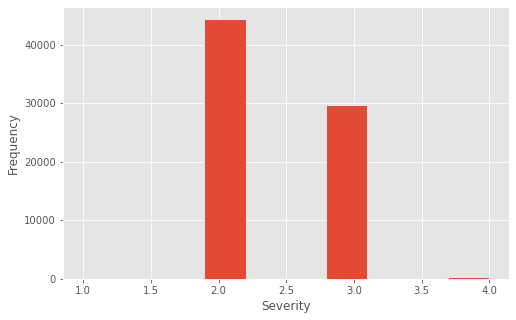

In [19]:
df_state['Severity'].plot(kind='hist', figsize=(8, 5))

plt.xlabel('Severity') # add x-label

plt.show()

**Step 2: When do the accidents occur?**

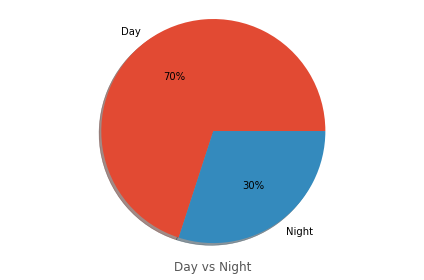

In [20]:
# Day vs Night
feature='Sunrise_Sunset'

# Cutoff percentage for display
pct_cutoff=2

# Define autopct: only display the value if the percentage is greater than the predefined cutoff value
def my_autopct(pct):
    return ('%1.0f%%' % pct) if pct > pct_cutoff else ''

df_temp=df_state[feature].value_counts(normalize=True).round(2)

# Define lables to go with the pie plot
labels = [n if v > pct_cutoff/100 else ''
              for n, v in zip(df_temp.index, df_temp)] 
    
# Generate the pie plot
plt.pie(df_temp, labels=labels, autopct=my_autopct, shadow=True)
    
# Set axis,label and title
plt.axis('equal')
plt.xlabel('Day vs Night')
    
plt.tight_layout()
plt.show()

Text(0.5, 0, '')

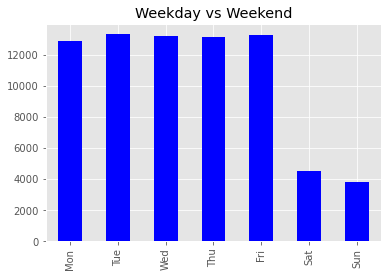

In [21]:
# Weekday vs Weekend
color_lst=['r','b','k']
weekday_lst = [ 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

df_state.groupby('Weekday').count()['ID'].reindex(weekday_lst).plot(kind='bar',color=color_lst[1]).set_title('Weekday vs Weekend')
plt.xlabel('')

**Step 3: Where do the accidents occur?**

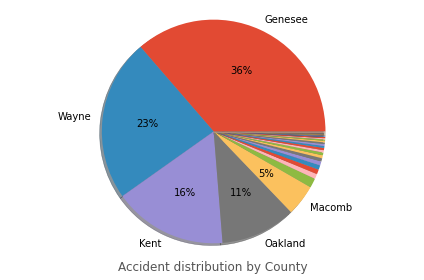

In [22]:
# accident distribution by county
feature='County'

# Cutoff percentage for display
pct_cutoff=2.5

# Define autopct: only display the value if the percentage is greater than the predefined cutoff value
def my_autopct(pct):
    return ('%1.0f%%' % pct) if pct > pct_cutoff else ''

df_temp=df_state[feature].value_counts(normalize=True).round(8)

# Define lables to go with the pie plot
labels = [n if v > pct_cutoff/100 else ''
              for n, v in zip(df_temp.index, df_temp)] 
    
# Generate the pie plot
plt.pie(df_temp, labels=labels, autopct=my_autopct, shadow=True)
    
# Set axis,label and title
plt.axis('equal')
plt.xlabel('Accident distribution by County')

plt.tight_layout()
plt.show()

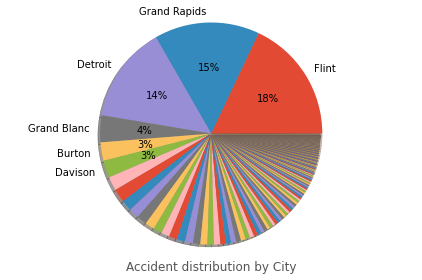

In [24]:
# accident distribution by city
feature='City'

# Cutoff percentage for display
pct_cutoff=2.5

# Define autopct: only display the value if the percentage is greater than the predefined cutoff value
def my_autopct(pct):
    return ('%1.0f%%' % pct) if pct > pct_cutoff else ''

df_temp=df_state[feature].value_counts(normalize=True).round(8)

# Define lables to go with the pie plot
labels = [n if v > pct_cutoff/100 else ''
              for n, v in zip(df_temp.index, df_temp)] 
    
# Generate the pie plot
plt.pie(df_temp, labels=labels, autopct=my_autopct, shadow=True)
    
# Set axis,label and title
plt.axis('equal')
plt.xlabel('Accident distribution by City')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Accident distribution by side of street')

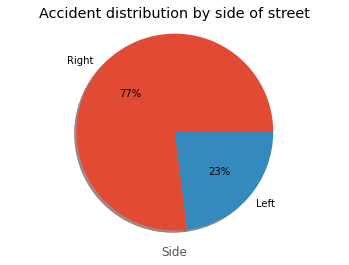

In [29]:
# accident distribution by side of street
feature='Side'

labels=['Right','Left']

df_side=df_state['Side'].value_counts(normalize=True).round(2)[:2]

plt.pie(df_side, labels=labels, autopct='%1.0f%%', shadow=True)

plt.axis('equal')
plt.xlabel(feature)
plt.title('Accident distribution by side of street')

**Step 4: What kind of Weather leads to the most accidents?**

In [30]:
df_state['Weather_Condition'].value_counts(normalize=True).round(5)

Clear                           0.22630
Overcast                        0.20621
Mostly Cloudy                   0.12246
Light Snow                      0.07414
Fair                            0.06942
Partly Cloudy                   0.06692
Light Rain                      0.06642
Cloudy                          0.05767
Scattered Clouds                0.05654
Rain                            0.01206
Haze                            0.00664
Fog                             0.00650
Snow                            0.00402
Heavy Rain                      0.00320
Light Drizzle                   0.00261
Light Freezing Rain             0.00219
Shallow Fog                     0.00166
Light Thunderstorms and Rain    0.00162
Cloudy / Windy                  0.00154
Light Freezing Drizzle          0.00107
Fair / Windy                    0.00103
Heavy Snow                      0.00100
Thunderstorm                    0.00097
Thunderstorms and Rain          0.00093
Heavy Thunderstorms and Rain    0.00080


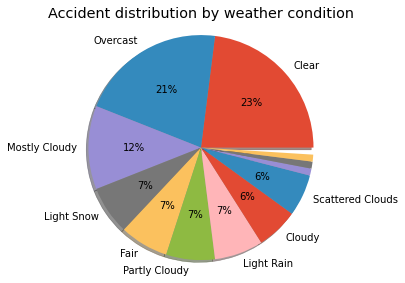

In [31]:
# accident distribution by weather condition
feature='Weather_Condition'
pct_cutoff=2
def my_autopct(pct):
    return ('%1.0f%%' % pct) if pct > pct_cutoff else ''

df_temp=df_state[feature].value_counts(normalize=True).round(2)

# Define lables to go with the pie plot
labels = [n if v > pct_cutoff/100 else ''
              for n, v in zip(df_temp.index, df_temp)] 
    
# Generate the pie plot
plt.pie(df_temp, labels=labels, autopct=my_autopct, shadow=True)
    
# Set axis,label and title
plt.axis('equal')
plt.title('Accident distribution by weather condition')

plt.tight_layout()
plt.show()

<ipython-input-39-b65c594168f6>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_temp=df_state[(df['Weather_Condition']==weather)][feature].value_counts(normalize=True).round(2)


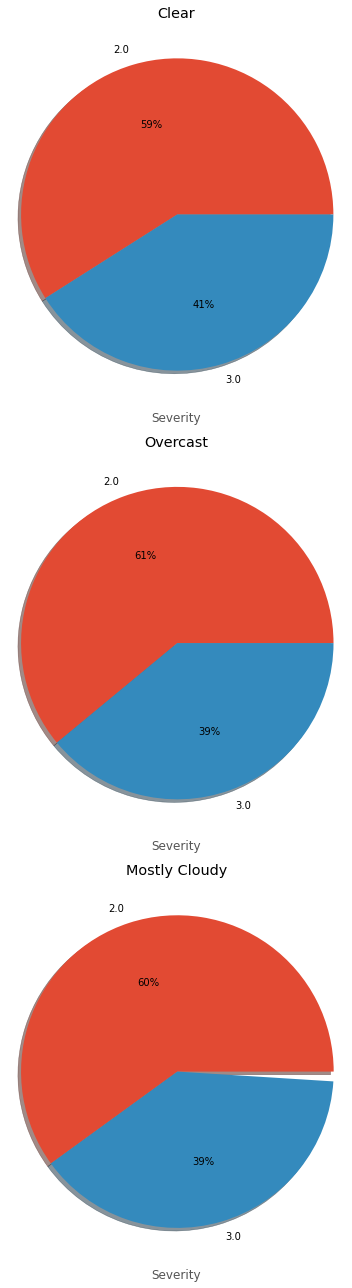

In [39]:
# accident severity for top three weather conditions
feature ='Severity'
weather_lst = ['Clear','Overcast','Mostly Cloudy']
fig_y = len(weather_lst)

fig = plt.figure(figsize=(5,6*fig_y))

pct_cutoff=0

def my_autopct(pct):
    return ('%1.0f%%' % pct) if pct > pct_cutoff else ''

# Run a for loop for each weather condition
for i,weather in enumerate(weather_lst):
    # Set a sub plot
    plt.subplot(fig_y, 1, i+1)
    # Slice the dataframe for the specific weather condition and feature
    df_temp=df_state[(df['Weather_Condition']==weather)][feature].value_counts(normalize=True).round(2)
    # Define lables to go with the pie plot
    labels = [n if v > pct_cutoff/100 else ''
              for n, v in zip(df_temp.index, df_temp)]
    # Generate the pie plot
    plt.pie(df_temp, labels=labels, autopct=my_autopct, shadow=True)
    
    # Set axis,label and title
    plt.axis('equal')
    plt.xlabel(feature)
    plt.title(weather)

plt.tight_layout()
plt.show()

<ipython-input-42-acf20705c1bd>:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_temp=df_sel[(df['State']==state) & (df['Severity']==severity)][feature].value_counts(normalize=True).round(2)


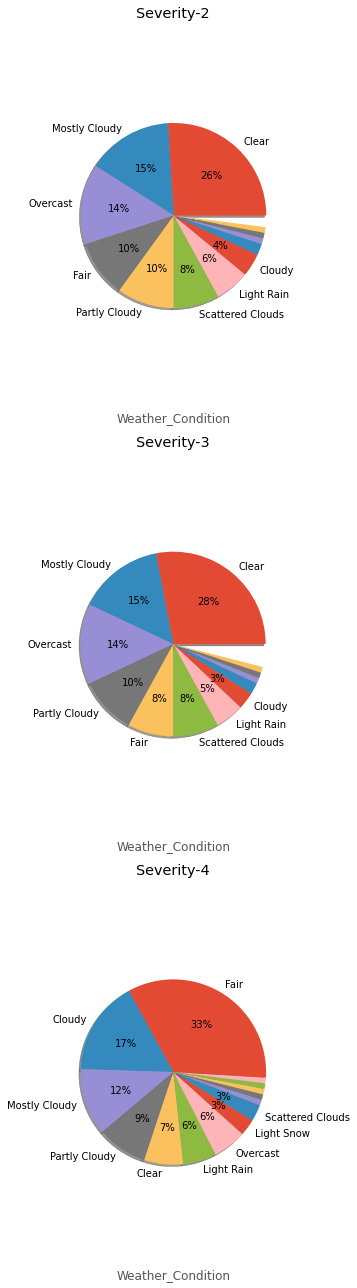

In [42]:
# Most common weather conditions for each accident severity
feature='Weather_Condition'
severity_lst=[2,3,4]
fig_x=1
fig_y=len(severity_lst)

# Set the size of the figure
fig= plt.figure(figsize=(5*fig_x,6*fig_y))

# Cutoff percentage for display
pct_cutoff=2

# Define autopct: only display the value if the percentage is greater than the predefined cutoff value
def my_autopct(pct):
    return ('%1.0f%%' % pct) if pct > pct_cutoff else ''


# Run a for loop for each weather condition
for i,severity in enumerate(severity_lst):
    
    # Set a sub plot
    plt.subplot(fig_y, fig_x, i*fig_x+1)
    # Slice the dataframe for the specific state, weather condition and feature
    df_temp=df_sel[(df['State']==state) & (df['Severity']==severity)][feature].value_counts(normalize=True).round(2)

    # Define lables to go with the pie plot
    labels = [n if v > pct_cutoff/100 else ''
            for n, v in zip(df_temp.index, df_temp)] 
    
    # Generate the pie plot
    plt.pie(df_temp, labels=labels, autopct=my_autopct, shadow=True)
    
    # Set axis,label and title
    plt.axis('equal')
    plt.xlabel(feature)
    plt.title('Severity-'+str(severity))

plt.tight_layout()
plt.show()

# Predictive Modelling

**Step 1: Data Pre-Processing**

In [54]:
# Assign the data
df=df_state_dummy
# Set the target for the prediction
target='Severity'

# set X and y
y = df[target]
X = df.drop(target, axis=1)

# Split the data set into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

In [55]:
# List of classification algorithms
algo_lst=['Logistic Regression',' K-Nearest Neighbors','Decision Trees','Random Forest']

# Initialize an empty list for the accuracy for each algorithm
accuracy_lst=[]

**Step 2: Applying Logistic Regression Algorithm**

In [56]:
# Logistic regression
lr = LogisticRegression(random_state=0)
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)

print("[Logistic regression algorithm] accuracy_score: {:.3f}.".format(acc))

[Logistic regression algorithm] accuracy_score: 0.787.


C:\Users\tripa\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Step 3: Applying KNN Algorithm**

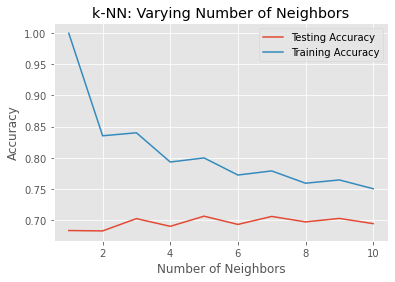

In [48]:
# Plotting accuracy vs the number of neighbours to optimize the number of neighbours

# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 11)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, n_neighbor in enumerate(neighbors):
    
    # Setup a k-NN Classifier with n_neighbor
    knn = KNeighborsClassifier(n_neighbors=n_neighbor)

    # Fit the classifier to the training data
    knn.fit(X_train,y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [57]:
# Create a k-NN classifier with 6 neighbors
knn = KNeighborsClassifier(n_neighbors=7)

# Fit the classifier to the data
knn.fit(X_train,y_train)

# Predict the labels for the training data X
y_pred = knn.predict(X_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)

print('[K-Nearest Neighbors (KNN)] knn.score: {:.3f}.'.format(knn.score(X_test, y_test)))
print('[K-Nearest Neighbors (KNN)] accuracy_score: {:.3f}.'.format(acc))

[K-Nearest Neighbors (KNN)] knn.score: 0.706.
[K-Nearest Neighbors (KNN)] accuracy_score: 0.706.


**Step 4: Applying Decision Tree Algorithm**

In [58]:
# Decision tree algorithm

# Instantiate dt_entropy, set 'entropy' as the information criterion
dt_entropy = DecisionTreeClassifier(max_depth=8, criterion='entropy', random_state=1)


# Fit dt_entropy to the training set
dt_entropy.fit(X_train, y_train)

# Use dt_entropy to predict test set labels
y_pred= dt_entropy.predict(X_test)

# Evaluate accuracy_entropy
accuracy_entropy = accuracy_score(y_test, y_pred)


# Print accuracy_entropy
print('[Decision Tree -- entropy] accuracy_score: {:.3f}.'.format(accuracy_entropy))



# Instantiate dt_gini, set 'gini' as the information criterion
dt_gini = DecisionTreeClassifier(max_depth=8, criterion='gini', random_state=1)


# Fit dt_entropy to the training set
dt_gini.fit(X_train, y_train)

# Use dt_entropy to predict test set labels
y_pred= dt_gini.predict(X_test)

# Evaluate accuracy_entropy
accuracy_gini = accuracy_score(y_test, y_pred)

# Append to the accuracy list
acc=accuracy_gini
accuracy_lst.append(acc)

# Print accuracy_gini
print('[Decision Tree -- gini] accuracy_score: {:.3f}.'.format(accuracy_gini))

[Decision Tree -- entropy] accuracy_score: 0.835.
[Decision Tree -- gini] accuracy_score: 0.846.


**Step 4: Applying Random forrest Classifier Algorithm**

In [59]:
# Random Forest Classifier Algorithm

# Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

# Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)

# Model Accuracy, how often is the classifier correct?
print("[Random forest algorithm] accuracy_score: {:.3f}.".format(acc))

[Random forest algorithm] accuracy_score: 0.873.


**Step 5: Comparing the accuracy of different machine learning algorithms**

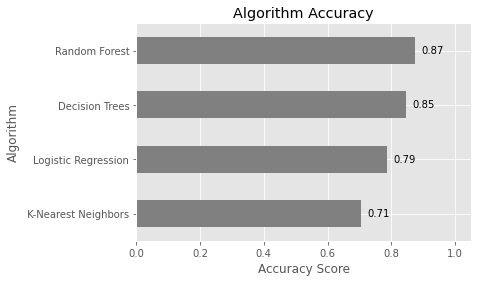

In [61]:
# Make a plot of the accuracy scores for different algorithms

# Generate a list of ticks for y-axis
y_ticks=np.arange(len(algo_lst))

# Combine the list of algorithms and list of accuracy scores into a dataframe, sort the value based on accuracy score
df_acc=pd.DataFrame(list(zip(algo_lst, accuracy_lst)), columns=['Algorithm','Accuracy_Score']).sort_values(by=['Accuracy_Score'],ascending = True)

# Make a plot
ax=df_acc.plot.barh('Algorithm', 'Accuracy_Score', align='center',legend=False,color='0.5')

# Add the data label on to the plot
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+0.02, i.get_y()+0.2, str(round(i.get_width(),2)), fontsize=10)

# Set the limit, lables, ticks and title
plt.xlim(0,1.05)
plt.xlabel('Accuracy Score')
plt.yticks(y_ticks, df_acc['Algorithm'], rotation=0)
plt.title('Algorithm Accuracy')

plt.show()